In [ ]:
!pip uninstall opencv-python opencv-python-headless -y
#!pip install opencv-python-headless

!pip uninstall opencv-contrib-python opencv-python -y
!pip install opencv-contrib-python
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
!pip install torchvision

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
import math as m

import torch
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import v2
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.ops import box_iou
import torchvision.transforms.functional as F
from torch import nn, device

import cv2
import seaborn as sns
from torchvision import transforms as T, models, datasets
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, average_precision_score

In [3]:
warnings.filterwarnings("ignore")

In [4]:
training_data = datasets.Kitti(
    root='data',
    train=True,
    download=True,
    transform=v2.ToTensor(),
)

test_data = datasets.Kitti(
    root='data',
    train=False,
    download=True,
    transform=v2.ToTensor(),
)

In [5]:
base_path = 'data/Kitti/raw'

train_images_path = sorted(
    [
        os.path.join(base_path, "training/image_2", fname) for fname in os.listdir(base_path + "/training/image_2") if fname.endswith(".png")
    ]
)

test_images_path = sorted(
    [
        os.path.join(base_path, "testing/image_2", fname) for fname in os.listdir(base_path + "/testing/image_2") if fname.endswith(".png")
    ]
)

print(len(train_images_path), len(test_images_path))

7481 7518


In [6]:
def get_bboxes(image):
    bboxes = []
    for i in range(len(image[1])):
        bboxes.append(image[1][i]['bbox'])
        
    result = torch.Tensor(bboxes)
    return result


def get_annotations(image):
    result = []
    for i in range(len(image[1])):
        bbox = {}
        for j, c in enumerate(['x1', 'y1', 'x2', 'y2']):
            bbox[c] = int(image[1][i]['bbox'][j])
        result.append(bbox)
    return result


def get_labels(image):
    result = []
    classes = {'Car': 0, 'Cyclist': 1, 'DontCare': 2, 'Misc': 3, 'Pedestrian': 4, 
    'Person_sitting': 5, 'Tram': 6, 'Truck': 7, 'Van': 8}
    for i in range(len(image[1])):
        result.append(classes[image[1][i]['type']])
        
    return result


def get_patch(bbox):
    width = bbox['x2'] - bbox['x1']
    height = bbox['y2'] - bbox['y1']
    
    x, y = bbox['x1'], bbox['y1']
    
    rectangle = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
    return rectangle

In [7]:
def imshow(image):
    if not isinstance(image, list):
        image = [image]
    fig, axes = plt.subplots(ncols=len(image), squeeze=False)
    for i, img in enumerate(image):
        img = img.detach()
        img = F.to_pil_image(img)
        axes[0, i].imshow(np.asarray(img))
        axes[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
        
def bbox_show(image):
    bboxes = get_annotations(image)
    for bbox in bboxes:
        imshow(image[0][:, bbox['y1']:bbox['y2'], bbox['x1']:bbox['x2']])
    
        
def show_image_with_bboxes(image):
    image = v2.ToDtype(torch.uint8, scale=True)(image)
    bboxes = get_bboxes(image)
    bboxes = torch.tensor(bboxes, dtype=torch.float)
    result = draw_bounding_boxes(image[0], bboxes, colors='red', width=5)
    imshow(result)

torch.Size([3, 370, 1224])


[4]

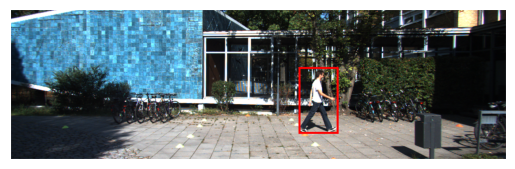

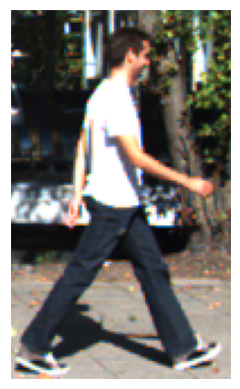

In [8]:
image = training_data[0]
print(image[0].shape)
show_image_with_bboxes(image)
bbox_show(image)
get_labels(image)

In [9]:
def get_bbox_area(bbox):
    w = bbox['x2'] - bbox['x1']
    h = bbox['y2'] - bbox['y1']
    return w * h


def get_iou(bbox1, bbox2):
    #   эта функция вычисляет пересечение между пространствами двух bbox

    x_left = max(bbox1['x1'], bbox2['x1'])
    x_right = min(bbox1['x2'], bbox2['x2'])
    y_top = max(bbox1['y1'], bbox2['y1'])
    y_bottom = min(bbox1['y2'], bbox2['y2'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    area = (x_right - x_left) * (y_bottom - y_top)
    
    bb1_area = (bbox1['x2'] - bbox1['x1']) * (bbox1['y2'] - bbox1['y1'])
    bb2_area = (bbox2['x2'] - bbox2['x1']) * (bbox2['y2'] - bbox2['y1'])
    
    iou = float(area) / (bb1_area + bb2_area - area)
    return iou

In [10]:
selSearch = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

def get_regions(image, base_k=150, inc_k=150, sigma=0.8):
    selSearch.setBaseImage(image)
    selSearch.switchToSelectiveSearchFast(base_k, inc_k, sigma)
    regions = selSearch.process()
    return regions


def compute_offset(g, p):
    px, py, pw, ph = p['x1'], p['y1'], p['x2'] - p['x1'], p['y2'] - p['y1']
    gx, gy, gw, gh = g['x1'], g['y1'], p['x2'] - g['x1'], g['y2'] - g['y1']
    dx = (gx - px) / pw
    dy = (gy - py) / ph
    dw = np.log(gw / pw)
    dh = np.log(gh / ph)
    return [dx, dy, dw, dh]


training_images = []
training_labels = []
training_bboxes = []

current = 0


def prepare_training_data(data, current):
    
    cvImg = cv2.imread(train_images_path[current])
    image = cv2.cvtColor(cvImg, cv2.COLOR_BGR2RGB)
        
    annotations = get_annotations(data)
    regions = get_regions(image)
    labels = get_labels(data)
        
    imout = image.copy()
        
    flag = 0
    t_counter = 0
    f_counter = 0
    for counter, bbox1 in enumerate(annotations):
        roi = image[bbox1['y1']:bbox1['y2'], bbox1['x1']:bbox1['x2']]
        roi = cv2.resize(roi, (224, 224), interpolation=cv2.INTER_AREA)
        training_images.append(roi)
        training_bboxes.append([0, 0, 0, 0])
        training_labels.append(labels[counter])
            
    for region in regions:
        if not flag:
            x, y, w, h = region
            bbox2 = {'x1': x, 'y1': y, 'x2': x+w, 'y2': y+h}
                
            ious = list(map(lambda bbox1: get_iou(bbox1, bbox2), annotations))
            ious = np.array(ious)
                
            ratios = list(map(lambda bbox1: get_bbox_area(bbox1)/get_bbox_area(bbox2), annotations))
                
            ratio_comparable = list(map(lambda r: (r >= 0.7 and r <= 1.3)*1, ratios))
                
            possibleTrue = ((ious > 0.7) * 1).max() == 1
            possibleFalse = ((ious > 0.3) * 1).max() == 0
            if t_counter < 30 and possibleTrue:
                gt = annotations[np.argmax(ious)]
                roi = imout[y:y+h, x:x+w]
                roi = cv2.resize(roi, (224, 224), interpolation=cv2.INTER_AREA)
                offset = compute_offset(gt, bbox2)
                    
                training_images.append(roi)
                training_bboxes.append(offset)
                training_labels.append(labels[np.argmax(ious)])
                t_counter += 1
                
            if f_counter < 12 and possibleFalse and max(ratio_comparable) == 1:
                roi = imout[y:y+h, x:x+w]
                roi = cv2.resize(roi, (224, 224), interpolation=cv2.INTER_AREA)
                training_images.append(roi)
                training_bboxes.append([0, 0, 0, 0])
                training_labels.append(3)
                f_counter += 1
                    
            if t_counter == 30 and f_counter == 12:
                flag = 1
        else:
            break

    #print(t_counter, f_counter, len(annotations), len(regions))
    #return training_images, training_labels, training_bboxes

AttributeError: module 'cv2.ximgproc' has no attribute 'segmentation'

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
size = 10000

for i in range(current, len(training_data)):
    print("Processing Image", i+1)
    prepare_training_data(training_data[i], current)
    current += 1
    if len(training_images) > size:
        break

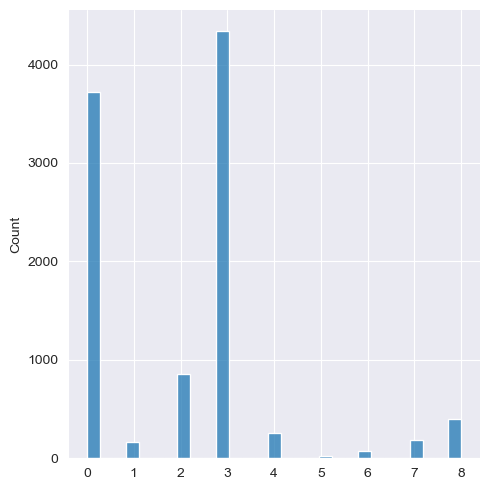

In [19]:
sns.displot(training_labels)

[7959 5764 3694 7450 6705 2743]


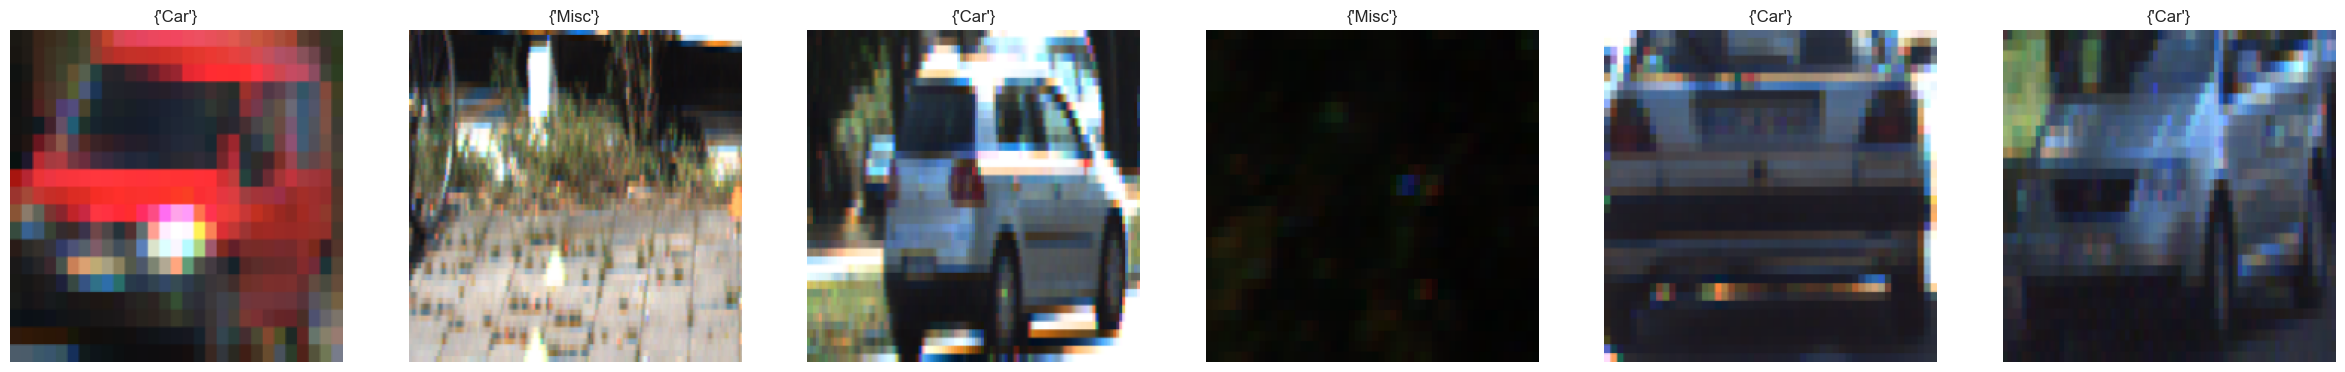

In [20]:
labels = {0: 'Car', 1: 'Cyclist', 2: 'DontCare', 3: 'Misc', 4: 'Pedestrian',
        5: 'Person_sitting', 6: 'Tram', 7: 'Truck', 8: 'Van'}

indices = np.random.randint(len(training_images), size=(6))
print(indices)
fig, axes = plt.subplots(1, 6, figsize=(30, 5))
for i in range(6):
    axes[i].imshow(training_images[indices[i]])
    axes[i].axis('off')
    axes[i].set_title({labels[training_labels[indices[i]]]})

plt.show()

In [21]:
def augmentation(training_images, training_labels, training_bboxes, transformer):
    classes = np.array(training_labels)
    unique_classes, counts = np.unique(training_labels, return_counts=True)
    most_freq_class = np.argmax(counts)

    transformed_images = []
    transformed_labels = []
    transformed_offsets = []

    for i in range(len(training_images)):
        cycles = len(classes[classes == most_freq_class])/len(classes[classes == training_labels[i]])
        if cycles >= 2:
            cycles = int(np.round(cycles-1))
            for j in range(cycles):
                transformed_images.append(torch.from_numpy(np.array(transformer(Image.fromarray(training_images[i])))))
                transformed_labels.append(training_labels[i])
                transformed_offsets.append(training_bboxes[i])
        print(f"Processing Image {i}")

    return transformed_images, transformed_labels, transformed_offsets

In [22]:
transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=45),
    T.ToTensor(),
])

In [ ]:
transformed_images, transformed_labels, transformed_offsets = augmentation(training_images, training_labels, training_bboxes, transform)

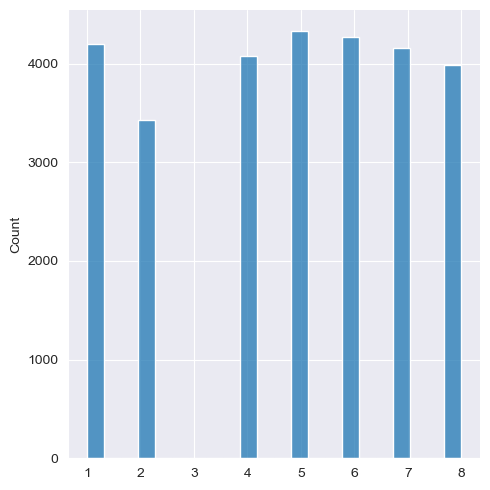

In [24]:
sns.displot(np.array(transformed_labels))

torch.Size([5, 3, 224, 224]) torch.Size([2, 3, 224, 224])


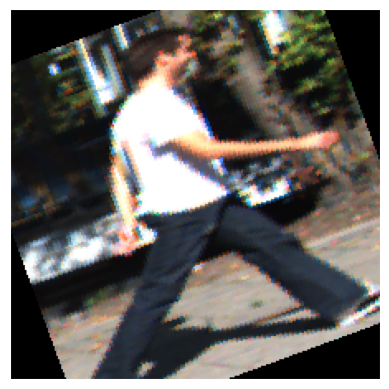

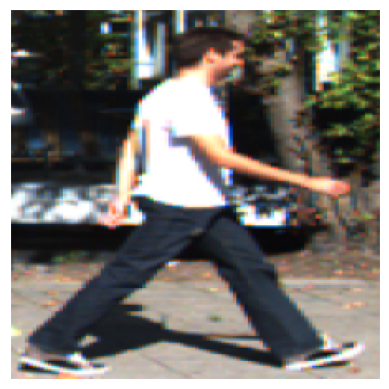

In [25]:
image_ = [transform(Image.fromarray(img)) for img in training_images[:5]]
#print(image_.shape)
image_ = v2.ToDtype(torch.float, scale=True)(torch.from_numpy(np.array(v2.ToTensor()(image_))))
image__ = v2.ToDtype(torch.float, scale=True)(torch.from_numpy(np.array(v2.ToTensor()(training_images[0:2]))))
print(image_.shape, image__.shape)

imshow(image_[0])
imshow(image__[0])

In [26]:
images = v2.ToDtype(torch.float, scale=True)(torch.from_numpy(np.array(v2.ToTensor()(training_images))))
labels = v2.ToDtype(torch.long)(torch.from_numpy(np.array(training_labels)))
offsets = torch.from_numpy(np.array(training_bboxes))

aug_images = v2.ToDtype(torch.float, scale=True)(torch.from_numpy(np.array(v2.ToTensor()(transformed_images))))
aug_labels = v2.ToDtype(torch.long)(torch.from_numpy(np.array(transformed_labels)))
aug_offsets = torch.from_numpy(np.array(transformed_offsets))

images = torch.cat([images, aug_images])
labels = torch.cat([labels, aug_labels])
offsets = torch.cat([offsets, aug_offsets])

print(images.shape, labels.shape, offsets.shape)

torch.Size([38462, 3, 224, 224]) torch.Size([38462]) torch.Size([38462, 4])


In [27]:
torch.save(images, 'models/R-CNN/data/images.pth')
torch.save(labels, 'models/R-CNN/data/labels.pth')
torch.save(offsets, 'models/R-CNN/data/offsets.pth')

In [12]:
images = torch.load('models/R-CNN/data/images.pth')
labels = torch.load('models/R-CNN/data/labels.pth')
offsets = torch.load('models/R-CNN/data/offsets.pth')
print(images.shape, labels.shape, offsets.shape)

torch.Size([38438, 3, 224, 224]) torch.Size([38438]) torch.Size([38438, 4])


In [28]:
def z_score_normalize(tensor):
    mean = tensor.mean()
    std = tensor.std()
    return (tensor - mean) / (std + 1e-8), mean, std

In [29]:
offsets_norm, mean, std = z_score_normalize(offsets)
mean, std
#10.8901, 31.1494

(tensor(10.8901, dtype=torch.float64), tensor(31.1494, dtype=torch.float64))

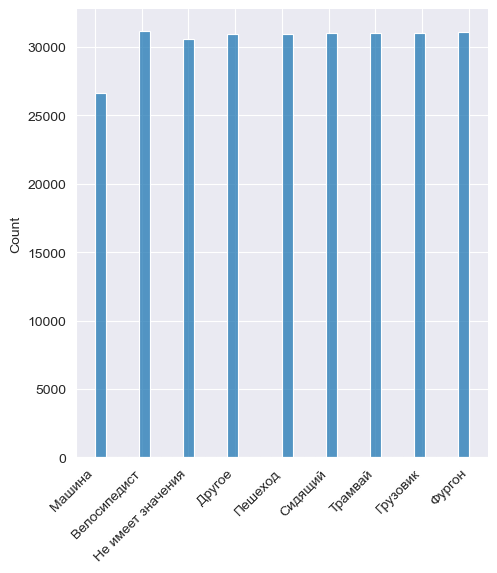

In [25]:
sns.displot(np.array(labels))

plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8], labels=['Машина', 'Велосипедист', 'Не имеет значения', 'Другое', 'Пешеход', 'Сидящий', 'Трамвай', 'Грузовик', 'Фургон'])
plt.yticks(ticks=np.arange(0, 4201, 700), labels=np.arange(0, 30001, 5000))
plt.xticks(rotation=45, ha='right')

plt.show()

In [31]:
dataset = TensorDataset(images, labels, offsets_norm)

In [32]:
torch.save(dataset, 'models/R-CNN/data/dataset.pth')

In [33]:
dataset = torch.load('models/R-CNN/data/dataset.pth', weights_only=False)

In [33]:
test_size = 4000
train_size = len(dataset) - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

torch.save(train_set, 'models/R-CNN/data/train_set.pth')
torch.save(test_set, 'models/R-CNN/data/test_set.pth')

In [13]:
train_set = torch.load('models/R-CNN/data/train_set.pth', weights_only=False)
test_set = torch.load('models/R-CNN/data/test_set.pth', weights_only=False)

In [14]:
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers = 0, shuffle=False)

In [15]:
def train_model(dataloader, model, classification_loss_fn, 
                regression_loss_fn, optimizer, callback=None):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y, of) in enumerate(dataloader):
        X, y, of = X.to(device), y.to(device), of.to(device).float()
        
        logits, bbox_reg = model(X)
        class_loss = classification_loss_fn(logits, y)
        
        pos_indices = y != 3
        if pos_indices.sum() > 0:
            #print(bbox_reg[pos_indices], of[pos_indices])
            reg_loss = regression_loss_fn(bbox_reg[pos_indices], of[pos_indices])
        else:
            reg_loss = torch.tensor(0.0)
            
        loss = class_loss + reg_loss
        #print(f"Class Loss = {class_loss}; Reg Loss = {reg_loss}; Final Loss = {loss}")
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if callback:
            callback(loss, batch)
            
            
def test_model(dataloader, model, test_type, callback, threshold=0.8):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch, (X, y, of) in enumerate(dataloader):
            X, y, of = X.to(device), y.to(device), of.to(device).float()
            logits, bbox_reg = model(X)
            logits = nn.functional.softmax(logits)
            pre_probs, pre_labels = torch.max(logits, dim=1)
            valid_pre = pre_probs >= threshold
            #print((pre_labels == y).sum(), valid_pre.sum())
            correct += ((pre_labels == y) & valid_pre).sum().item()
        correct /= size
        accuracy = round(100*correct, 3)
        if callback:
            callback(accuracy)
        print(f"{test_type} Accuracy: {accuracy}%")
        return model, accuracy

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
class Rcnn(nn.Module):
    def __init__(self, ):
        super(Rcnn, self).__init__()
        
        backbone = models.vgg16(pretrained=True)
        self.features = backbone.features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
        )
        
        self.classifier = nn.Linear(in_features=4096, out_features=9)
        self.regressor = nn.Linear(in_features=4096, out_features=4)
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x) 
        logits = self.classifier(x)
        box_rg = self.regressor(x)
        return logits, box_rg

In [18]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [19]:
model = Rcnn()

for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)

current_epoch = 0

In [20]:
model.load_state_dict(torch.load('models/R-CNN/model_weights.pth', weights_only=True))

<All keys matched successfully>

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay = 1e-5)
classification_loss_fn = nn.CrossEntropyLoss()
regression_loss_fn = nn.MSELoss()

loss_history = []
train_acc = []
test_acc = []

best_model = model
best_acc = 0

num_epochs = 10

def callback(loss, batch):
    if batch % 2 == 0:
        loss_history.append(loss.item())
    if batch % 10 == 0:
        print(f"Batch: {batch}; Loss: {loss.item()}")
    
for epoch in range(num_epochs):
    model = model.to(device)
    #optimizer = torch.optim.Adam(model.parameters(), lr=10**(-3-(current_epoch % 5)), weight_decay = 1e-5)
    print(f'----- Epoch {current_epoch} -----')
    train_model(train_loader, model, classification_loss_fn, 
                regression_loss_fn, optimizer, callback)
    print(f"Average Loss: {np.array(loss_history).mean()}")
    loss_history = []
    #test_model(train_loader, model, "Training", lambda acc: train_acc.append(acc), thresold=0.3)
    mod, acc = test_model(test_loader, model, "Testing", lambda acc: test_acc.append(acc), threshold=0.7)
    if acc > best_acc:
        best_acc = acc
        best_model = mod
    torch.save(best_model.cpu().state_dict(), f'models/R-CNN/model_weights_{current_epoch}.pth')
    current_epoch += 1

----- Epoch 16 -----
Batch: 0; Loss: 0.08766243606805801
Batch: 10; Loss: 0.15760964155197144
Batch: 20; Loss: 0.0023995523806661367
Batch: 30; Loss: 0.012825466692447662
Batch: 40; Loss: 0.03041038289666176
Batch: 50; Loss: 0.0061829574406147
Batch: 60; Loss: 0.004766514524817467
Batch: 70; Loss: 0.012300346046686172
Batch: 80; Loss: 0.03429069370031357
Batch: 90; Loss: 0.09374166280031204
Batch: 100; Loss: 0.1429559886455536
Batch: 110; Loss: 0.00788857601583004
Batch: 120; Loss: 0.007108773570507765
Batch: 130; Loss: 0.06927622109651566
Batch: 140; Loss: 0.03960466384887695
Batch: 150; Loss: 0.048356879502534866
Batch: 160; Loss: 0.026380568742752075
Batch: 170; Loss: 0.040678251534700394
Batch: 180; Loss: 0.035072583705186844
Batch: 190; Loss: 0.002853159559890628
Batch: 200; Loss: 0.0054322793148458
Batch: 210; Loss: 0.0026320097967982292
Batch: 220; Loss: 0.013066546991467476
Batch: 230; Loss: 0.014133536256849766
Batch: 240; Loss: 0.01872442103922367
Batch: 250; Loss: 0.02093771

KeyboardInterrupt: 

In [32]:
def calculate_metrics(dataloader, model, prob_threshold=0.5, iou_threshold=0.0):

    all_pred_labels = []
    all_true_labels = []

    for batch, (X, true_labels, true_boxes) in enumerate(dataloader):
        X, true_labels, true_boxes = X.to(device), true_labels.to(device), true_boxes.to(device).float()
        logits, pred_boxes = model(X)
        logits = nn.functional.softmax(logits)
        pre_probs, pred_labels = torch.max(logits, dim=1)
        #print(true_boxes, pred_boxes)

        indices = pre_probs < prob_threshold
        pred_labels[indices] = -1
        pred_boxes[indices] = torch.tensor([1000.0, 1000.0, 1000.0, 1000.0]).to(device).float()
        #print(true_boxes, pred_boxes)

        iou_matrix = box_iou(pred_boxes, true_boxes).diag()
        matched_indices = iou_matrix < iou_threshold
        pred_labels[matched_indices] = -1
        #print(len(pred_labels[pred_labels == -1]))

        all_pred_labels.extend(pred_labels.cpu().tolist())
        all_true_labels.extend(true_labels.cpu().tolist())

    # Если нет совпадений, возвращаем нули
    if len(all_pred_labels) == 0:
        #print("Accuracy: 0%")
        print("Precision: 0%")
        print("Recall: 0%")
        print("F1-Score: 0%")
        return 0.0, 0.0, 0.0, 0.0

    # Вычисление метрик
    #accuracy = accuracy_score(all_true_labels, all_pred_labels)
    precision = precision_score(all_true_labels, all_pred_labels, average='macro', zero_division=0)
    recall = recall_score(all_true_labels, all_pred_labels, average='macro', zero_division=0)
    f1 = f1_score(all_true_labels, all_pred_labels, average='macro', zero_division=0)

    #print(f"Accuracy: {accuracy*100:.3f}%")
    print(f"Precision: {precision*100:.3f}%")
    print(f"Recall: {recall*100:.3f}%")
    print(f"F1-Score: {f1*100:.3f}%")

    return round(precision*100, 3), round(recall*100, 3), round(f1*100, 3)

In [31]:
precision, recall, f1 = calculate_metrics(test_loader, model, prob_threshold=0.5)

Precision: 87.978%
Recall: 87.795%
F1-Score: 87.884%


In [41]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
prob_threshold_list = []
for prob_threshold in np.arange(0.01, 0.95, 10):
    accuracy, precision, recall, f1 = calculate_metrics(test_loader, model, prob_threshold=prob_threshold)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

Accuracy: 97.575%
Precision: 97.581%
Recall: 97.575%
F1-Score: 97.575%
Accuracy: 97.550%
Precision: 97.550%
Recall: 97.523%
F1-Score: 97.532%
Accuracy: 97.575%
Precision: 97.576%
Recall: 97.573%
F1-Score: 97.571%
Accuracy: 97.775%
Precision: 97.772%
Recall: 97.775%
F1-Score: 97.771%
Accuracy: 97.625%
Precision: 97.633%
Recall: 97.620%
F1-Score: 97.624%
Accuracy: 97.750%
Precision: 97.744%
Recall: 97.750%
F1-Score: 97.740%
Accuracy: 97.700%
Precision: 97.695%
Recall: 97.695%
F1-Score: 97.691%
Accuracy: 97.675%
Precision: 87.948%
Recall: 87.898%
F1-Score: 87.919%
Accuracy: 97.500%
Precision: 87.799%
Recall: 87.735%
F1-Score: 87.765%
Accuracy: 97.500%
Precision: 87.886%
Recall: 87.737%
F1-Score: 87.807%
Accuracy: 97.275%
Precision: 87.797%
Recall: 87.551%
F1-Score: 87.669%
Accuracy: 97.500%
Precision: 88.390%
Recall: 87.752%
F1-Score: 88.062%
Accuracy: 96.775%
Precision: 87.777%
Recall: 87.092%
F1-Score: 87.427%
Accuracy: 97.025%
Precision: 88.424%
Recall: 87.315%
F1-Score: 87.857%
Accura

In [44]:
accuracy_list = np.array(accuracy_list)
precision_list = np.array(precision_list)
recall_list = np.array(recall_list)
f1_list = np.array(f1_list)
prob_threshold_list = [round(i, 2) for i in np.arange(0.0, 0.96, 0.05)]
prob_threshold_list.append(0.99)
prob_threshold_list.append(1.0)
print(accuracy_list)
print(precision_list)
print(recall_list)
print(f1_list)
print(prob_threshold_list)

[97.575 97.55  97.575 97.775 97.625 97.75  97.7   97.675 97.5   97.5
 97.275 97.5   96.775 97.025 96.95  96.3   96.375 95.65  95.225 93.675
 91.175 51.125]
[97.581 97.55  97.576 97.772 97.633 97.744 97.695 87.948 87.799 87.886
 87.797 88.39  87.777 88.424 88.583 88.626 88.768 88.924 88.998 89.013
 89.499 89.965]
[97.575 97.523 97.573 97.775 97.62  97.75  97.695 87.898 87.735 87.737
 87.551 87.752 87.092 87.315 87.235 86.666 86.735 86.083 85.692 84.271
 82.048 45.919]
[97.575 97.532 97.571 97.771 97.624 97.74  97.691 87.919 87.765 87.807
 87.669 88.062 87.427 87.857 87.898 87.627 87.733 87.456 87.29  86.538
 85.54  59.631]
[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 1.0]


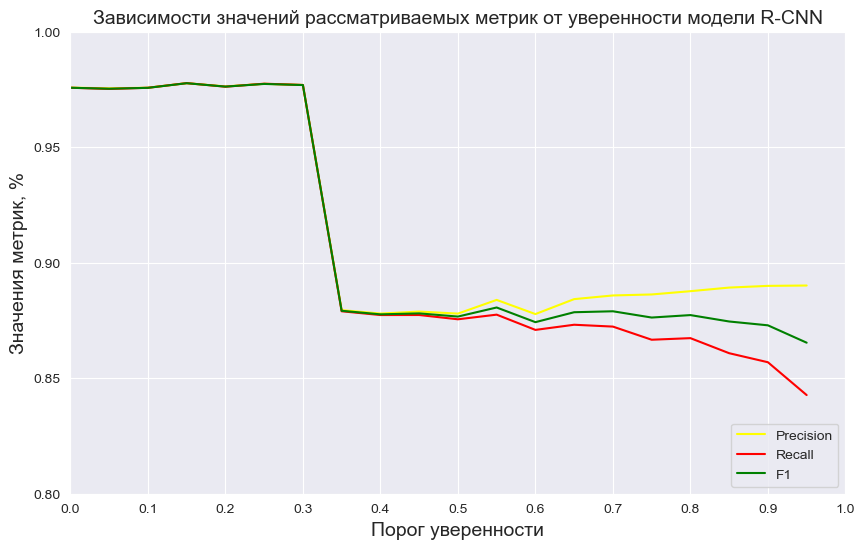

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(prob_threshold_list, np.array(precision_list)/100, label='Precision', color='yellow', linewidth='1.5')
ax.plot(prob_threshold_list, np.array(recall_list)/100, label='Recall', color='red', linewidth='1.5')
ax.plot(prob_threshold_list, np.array(f1_list)/100, label='F1', color='green', linewidth='1.5')


ax.set_xlabel('Порог уверенности', fontsize=14)
ax.set_ylabel('Значения метрик, %', fontsize=14)
ax.set_title('Зависимости значений рассматриваемых метрик от уверенности модели R-CNN', fontsize=14)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.01, 0.05))
ax.legend(loc='lower right')

ax.legend(loc='lower right')
ax.axis([0, 1, 0.8, 1.0])
plt.show()

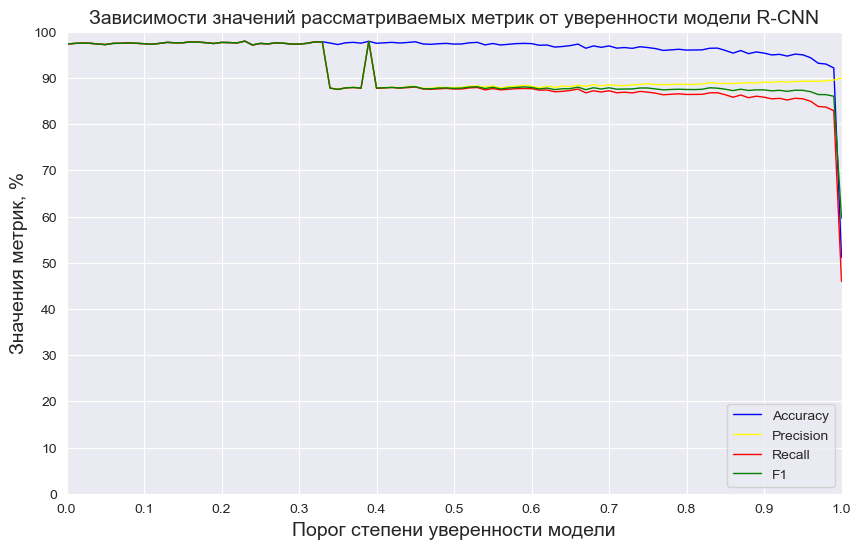

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(prob_threshold_list, accuracy_list, label='Accuracy', color='blue', linewidth='1')
ax.plot(prob_threshold_list, precision_list, label='Precision', color='yellow', linewidth='1')
ax.plot(prob_threshold_list, recall_list, label='Recall', color='red', linewidth='1')
ax.plot(prob_threshold_list, f1_list, label='F1', color='green', linewidth='1')


ax.set_xlabel('Порог степени уверенности модели', fontsize=14)
ax.set_ylabel('Значения метрик, %', fontsize=14)
ax.set_title('Зависимости значений рассматриваемых метрик от уверенности модели R-CNN', fontsize=14)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 101, 10))
ax.legend(loc='lower right')

ax.legend(loc='lower right')
ax.axis([0, 1, 0, 100])
plt.show()

In [35]:
def z_score_denormalize(tensor):
    mean = 0.0014
    std = 0.0645
    return tensor * std + mean

#0.0014, 0.0645
#10.8901, 31.1494
def get_region_masks(image, regions):
    region_images = []
    region_bboxes = []

    imout = image.copy()
    max_regions = 500
    for e, region in enumerate(regions):
        if (e < max_regions): 
            x, y, w, h = region
            bbox = {'x1': x, 'y1': y, 'x2': x+w, 'y2': y+h}

            roi = imout[y:y+h,x:x+w]
            roi = cv2.resize(roi, (224, 224), interpolation=cv2.INTER_AREA)
            region_images.append(roi)
            region_bboxes.append(bbox)
        else:
            break

    region_images = v2.ToDtype(torch.float, scale=True)(v2.ToTensor()(region_images))
    
    return region_images, region_bboxes


def get_chunks(region_images, chunk_size=200):

    chunks = []
    for i in range(0, len(region_images), chunk_size):
        chunk = region_images[i:i+chunk_size]
        chunks.append(chunk)
    return chunks


def apply_offsets(proposed, offsets):
    px, py, pw, ph = proposed
    dx, dy, dw, dh = offsets
    gx = px + dx * pw
    gy = py + dy * ph
    gw = pw * np.exp(dw)
    gh = ph * np.exp(dh)
    return [gx, gy, gw, gh]


def get_candidates(image, model, chunks, region_bboxes, chunk_size, required_object, threshold=0.8):
    classes = {'Car': 0, 'Cyclist': 1, 'DontCare': 2, 'Misc': 3, 'Pedestrian': 4, 
    'Person_sitting': 5, 'Tram': 6, 'Truck': 7, 'Van': 8}

    required_label = classes[required_object]
        
    model.eval()
    bboxes = []
    scores = []
    with torch.no_grad():
        for i, X in enumerate(chunks):
            X = torch.from_numpy(np.array(X))
            X= X.to(device)
            logits, box_reg = model(X)
            #print(i)
            logits = logits.cpu()
            box_reg = box_reg.cpu()
            box_reg = z_score_denormalize(box_reg)
            logits = nn.functional.softmax(logits, dim=1)
            pre_probs, pre_labels = torch.max(logits, dim=1)
            valid_pre = pre_probs >= threshold
            correct = ((pre_labels == required_label) & valid_pre).float()
            indices = torch.where(correct == 1)
            for j in range(len(indices[0])):
                bb_i = i*chunk_size + int(indices[0][j])
                box = region_bboxes[bb_i]
                proposed = [box['x1'], box['y1'], box['x2']-box['x1'], box['y2']-box['y1']]
                offset = box_reg[indices[0][j]]
                refined_box = apply_offsets(proposed, offset)
                
                bboxes.append([refined_box[0], refined_box[1], refined_box[0]+refined_box[2], refined_box[1]+refined_box[3]])
                scores.append(pre_probs[indices[0][j]])
    return torch.tensor(bboxes), torch.tensor(scores)


def non_maximum_supression(bboxes, scores, threshold=0.5):
    if len(bboxes) == 0:
        return torch.empty((0,))

    # Coordinates of bounding boxes
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]
    
    # Compute area of each bounding box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    
    # Sort the bounding boxes by scores in descending order
    _, order = scores.sort(0, descending=True)
    
    keep = []
    while order.numel() > 0:
        if order.numel() == 1:
            i = order.item()
            keep.append(i)
            break
        else:
            i = order[0].item()
            keep.append(i)

            xx1 = torch.max(x1[i], x1[order[1:]])
            yy1 = torch.max(y1[i], y1[order[1:]])
            xx2 = torch.min(x2[i], x2[order[1:]])
            yy2 = torch.min(y2[i], y2[order[1:]])

            w = torch.clamp(xx2 - xx1 + 1, min=0.0)
            h = torch.clamp(yy2 - yy1 + 1, min=0.0)
            
            inter = w * h
            rem_areas = areas[order[1:]]
            union = (rem_areas - inter) + areas[i]
            IoU = inter / union
            
            inds = (IoU <= threshold).nonzero(as_tuple=False).squeeze()
            order = order[inds + 1]
    
    return torch.tensor(keep, dtype=torch.int64)


def plot_detections(image, selected_bboxes):
    image = v2.ToDtype(torch.uint8, scale=True)(v2.ToTensor()(image))
    bboxes = torch.tensor(selected_bboxes, dtype=torch.float)
    result = draw_bounding_boxes(image, bboxes, colors='red', width=5)
    imshow(result)
    

def detect_objects(model, image_ind, required_object, chunk_size=4, threshold=0.8):
    cvImg = cv2.imread(test_images_path[image_ind])
    image = cv2.cvtColor(cvImg, cv2.COLOR_BGR2RGB)
    regions = get_regions(image, base_k=800, inc_k=300, sigma=0.2)
    print(len(regions))
    region_images, region_bboxes = get_region_masks(image, regions)
    chunks = get_chunks(region_images, chunk_size)
    bboxes, scores = get_candidates(image, model, chunks, region_bboxes, chunk_size, required_object, threshold=threshold)
    keep_indices = non_maximum_supression(bboxes, scores, threshold=0.3)

    if len(keep_indices) == 0:
        image = v2.ToDtype(torch.uint8, scale=True)(v2.ToTensor()(image))
        imshow(image)
        return

    selected_bboxes = bboxes[keep_indices]
    print(len(selected_bboxes))
    selected_scores = scores[keep_indices]

    plot_detections(image, selected_bboxes)

2756
10


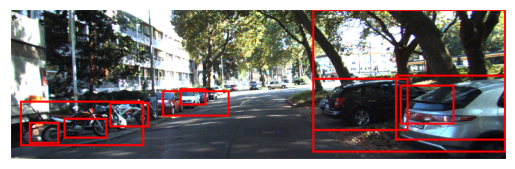

In [37]:
#Пример
detect_objects(model, image_ind=2, required_object='Car', threshold=0.95)

3862
3


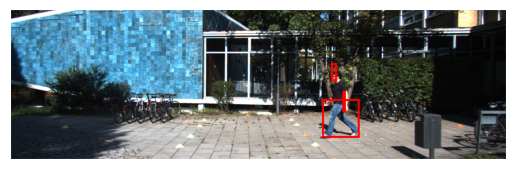

In [43]:
#Пример
detect_objects(model, image_ind=9, required_object='Pedestrian', threshold=0.99)

3428
4
3573


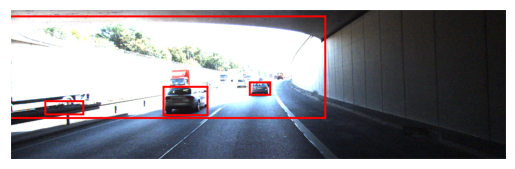

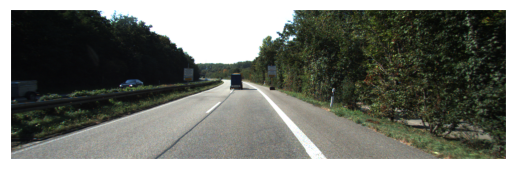

In [34]:
#Пример
detect_objects(model, image_ind=3, required_object='Car')
detect_objects(model, image_ind=4, required_object='Car')